### Buiding a chatbot with langgraph

In [170]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [171]:
class State(TypedDict):
  messages:Annotated[list,add_messages]
graph_builder=StateGraph(State)


In [172]:
import os
from dotenv import load_dotenv
load_dotenv()
GROQ_API_KEY=os.getenv("GROQ_API_KEY")

In [173]:
from langchain_groq import ChatGroq
llm=ChatGroq(api_key=GROQ_API_KEY,model="llama-3.1-8b-instant",temperature=0.7)

In [174]:
def chatbot(state:State):#since the input state is of type dict, we are trying to inherit from State
  return {"messages":[llm.invoke(state["messages"])]}

In [175]:
graph_builder=StateGraph(State)
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")#specfiying the node name not the fuction name
graph_builder.add_edge("chatbot",END)

#compile the graph
graph=graph_builder.compile()

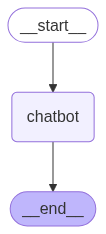

In [176]:
#visualize the graph
from IPython.display import Image,display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [177]:
response=graph.invoke({"messages":"hi"})

In [178]:
response["messages"][-1].content#the message is added in a list by the help of the annotation that act as a reducer


'Hello. Is there something I can help you with or would you like to chat?'

In [179]:
for event in graph.stream({"messages":"hi how are you?"}):
  for value in event.values():
    print(value["messages"][-1].content)

I'm doing well, thank you for asking. I'm a large language model, so I don't have feelings in the same way humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How about you? How's your day going?


In [180]:
from langchain_tavily import TavilySearch
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [181]:
tool = TavilySearch(api_key=TAVILY_API_KEY, max_results=2)
tool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by model

In [182]:
def multiply(a:int,b:int)->int:
  """Multiply a and b
  Args:
    a (int): first number
    b (int): second number
    Returns:
      int: output int"""
  return a*b

In [183]:
tools=[tool,multiply]#here we added both the tools(tavily search and multiply function) to a list

In [184]:
llm_with_tools=llm.bind_tools(tools)#here we bind the tools to the llm

In [185]:
#stategraph with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()#this will save the conversation in memory
#node definition
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}
#GRAPH
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#creating edges(this includes conditional edges)
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
  "tool_calling_llm",
  tools_condition
)
builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tool_calling_llm",END)

graph=builder.compile(checkpointer=memory)#this compiles the graph and implements the logic

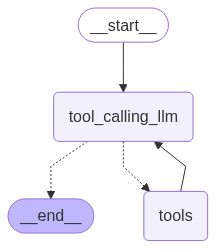

In [186]:
from IPython.display import Image,display
try:   
  display(Image(builder.compile().get_graph().draw_mermaid_png()))
except Exception:
  pass

In [187]:
#creating a config for memory
config={"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"hello,my name is shubham"},config=config)
response["messages"][-1].pretty_print()


================================== Ai Message ==================================

Nice to meet you, Shubham. How can I assist you today?


In [189]:
response=graph.invoke({"messages":"what is my name as mentioned previously?"},config=config)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Shubham.


##streaming techniques